# Model for detecting Fraudlent Transactions
---

## Overview
This project addresses a real-world fraud detection challenge for a financial services company. The objective is to build a predictive model capable of identifying fraudulent transactions from a large dataset containing over 6.3 million records and 10 features. The model must be trained, validated, and interpreted to support proactive fraud mitigation strategies. Beyond predictive accuracy, the task emphasizes thorough data cleaning (handling missing values, outliers, and multicollinearity), intelligent feature selection, and robust model evaluation using appropriate statistical tools. A critical component of this assignment is interpreting model outputs to identify key fraud-driving factors, assessing their validity, and translating those insights into actionable prevention measures. The effectiveness of these measures must also be considered from an implementation and monitoring standpoint, ensuring that model-driven interventions lead to measurable improvements in fraud control.

## Prerequisites

Installing libraries, step can be skipped if already installed.

In [ ]:
!pip install duckdb joblib pandas numpy matplotlib seaborn scikit-learn lightgbm shap statsmodels

Importing libraries, step can be skipped if already imported.

In [2]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
import joblib
RSEED = 42 #So that the randomness is reproducable.

---
Getting a sample of 10 to see the data we are going to work with.

In [3]:
file_path = "Fraud.csv" #Here you need to put the file name and path from jupyter directory, the direct path to the file from windows explorer can also be used but would produce a warning.
con = duckdb.connect()
df = con.execute(f"SELECT * FROM read_csv_auto('{file_path}', ignore_errors=true) LIMIT 10").fetchdf()
display(df)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


We are going to reinitialize df with random entries from the data and a bigger sample size to work with, so it fair and the insights are more realistic.

In [4]:
df = con.execute(f"SELECT * FROM read_csv_auto('{file_path}') ORDER BY RANDOM() LIMIT 200000").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Data cleaning
From here on we are going to be doing basic cleaning of the data.

### Ensuring correct data types
Here we are going to check the data types of all the columns and check against the Data Dictionary to see if they are correct, if not we are going to correct them.

In [5]:
data_types = con.execute(f"DESCRIBE SELECT * FROM read_csv_auto('{file_path}', ignore_errors=true)").fetchdf()
print(data_types)

       column_name column_type null   key default extra
0             step      BIGINT  YES  None    None  None
1             type     VARCHAR  YES  None    None  None
2           amount      DOUBLE  YES  None    None  None
3         nameOrig     VARCHAR  YES  None    None  None
4    oldbalanceOrg      DOUBLE  YES  None    None  None
5   newbalanceOrig      DOUBLE  YES  None    None  None
6         nameDest     VARCHAR  YES  None    None  None
7   oldbalanceDest      DOUBLE  YES  None    None  None
8   newbalanceDest      DOUBLE  YES  None    None  None
9          isFraud      BIGINT  YES  None    None  None
10  isFlaggedFraud      BIGINT  YES  None    None  None


The data types are a good match for the data in the table, so we are going to leave it unchanged.

### Missing values
Checking how many missing values there are.

In [6]:
missing_report = df.isnull().sum()
print("Missing values per column:\n", missing_report)

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Since there are 0 missing values per column we are going to leave it as it is and not try to change any of the data.

### Duplicate row removal
We are going to remove duplicate rows and see how many rows we are left with.

In [7]:
print(f"Before removing duplicates: {len(df)} rows")
df.drop_duplicates(inplace=True)
print(f"After removing duplicates: {len(df)} rows")

Before removing duplicates: 200000 rows
After removing duplicates: 200000 rows


There were no duplicate rows in the data.

### Outlier removal

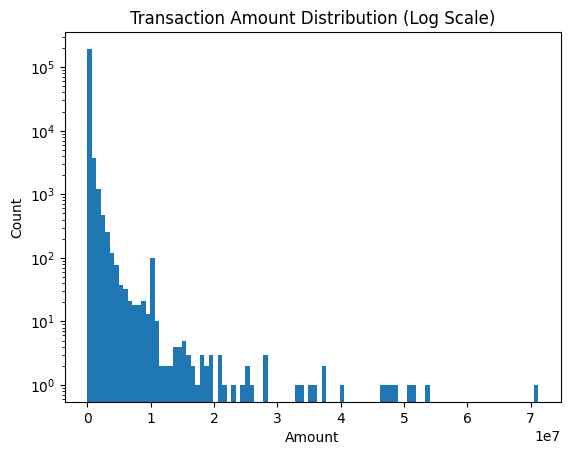

In [8]:
plt.hist(df['amount'], bins=100, log=True)
plt.title('Transaction Amount Distribution (Log Scale)')
plt.xlabel('Amount'); plt.ylabel('Count')
plt.show()

The plot tells us that most of the transaction are done with small amount by indicating a heavier left side and transactions with high amounts are low in quantity.

Now we are going to run a command that will remove negative amounts from the data.

In [9]:
df = df[df['amount'] > 0]

### Logical checks
Here we are going to check the data using basic logics, like
- oldbalanceOrg - amount ≈ newbalanceOrig (New balance should be the amount transacted subtracted from the oldbalance)
- newbalanceDest ≈ oldbalanceDest + amount

In [10]:
tol = 1.0
# Logic 1: oldbalanceOrg - amount ≈ newbalanceOrig
df['orig_balance_diff'] = np.abs(df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig'])
df = df[df['orig_balance_diff'] <= tol]

# Logic 2: newbalanceDest ≈ oldbalanceDest + amount (for non-merchant accounts)
is_not_merchant = ~df['nameDest'].astype(str).str.startswith('M')
df['dest_balance_diff'] = np.abs(df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'])
df = df[(df['dest_balance_diff'] < tol) | (~is_not_merchant)]  # allow if merchant

### Removing rows with obvious data errors
We will be removing rows where there are negative balances, as most likely the system wouldn't have allowed for an account to go into negative balance.

In [11]:
df = df[(df['oldbalanceOrg'] >= 0) & (df['newbalanceOrig'] >= 0)]
df = df[(df['oldbalanceDest'] >= 0) & (df['newbalanceDest'] >= 0)]

### Final shape and check of the data

In [12]:
print(f"Cleaned dataset shape: {df.shape}")
print(df.head())

Cleaned dataset shape: (41812, 13)
    step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2      9   PAYMENT   15222.80   C170791303        56453.0        41230.20   
5    131   PAYMENT    8168.48  C1037951222        55377.0        47208.52   
7    231  TRANSFER  147524.70  C1912424131       582748.0       435223.30   
8    129  CASH_OUT    4498.91   C733388674        29945.0        25446.09   
18   165   PAYMENT    1035.52    C44836442       307923.0       306887.48   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
2   M1675363851            0.00            0.00        0               0   
5    M229019138            0.00            0.00        0               0   
7    C893375210            0.00       147524.70        0               0   
8    C266963012       425181.46       429680.37        0               0   
18  M2065536605            0.00            0.00        0               0   

    orig_balance_diff  dest_balance_diff  
2 

### Adding some useful columns
Useful columns like log_amount, balance changes, etc. are added to the data here.

In [13]:
df['log_amount'] = np.log1p(df['amount'])
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']
df['is_merchant_dest'] = df['nameDest'].astype(str).str.startswith('M').astype(int)
df['type_cat'] = pd.Categorical(df['type']).codes

features = ['log_amount', 'orig_balance_change', 'dest_balance_change', 'is_merchant_dest', 'type_cat']

### VIF check (multicollinearity)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = df[features].fillna(0)   # ensure no NaNs
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_data.sort_values('VIF', ascending=False))

               feature         VIF
1  orig_balance_change  276.183132
2  dest_balance_change  272.951972
4             type_cat   26.044837
3     is_merchant_dest   24.479207
0           log_amount    4.505599


## Exploratory Data Analysis (EDA)

### Check imbalance
Showing count of fraudulent vs non-fraudulent transactions

Fraud rate: 0.3157%


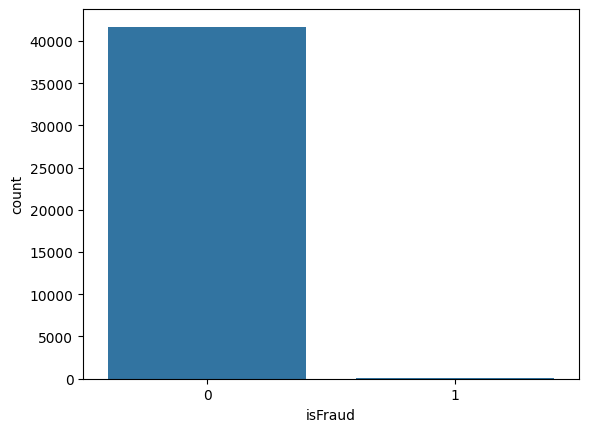

In [15]:
sns.countplot(x='isFraud', data=df)
fraud_rate = df['isFraud'].mean()
print(f"Fraud rate: {fraud_rate:.4%}") #.4 means percentage will be formatted to 4 decimal places.

### Transaction type vs fraud rate
Shows which types of transactions are more prone to fraud.

type
CASH_OUT    0.017981
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.000000
Name: isFraud, dtype: float64


<Axes: xlabel='type'>

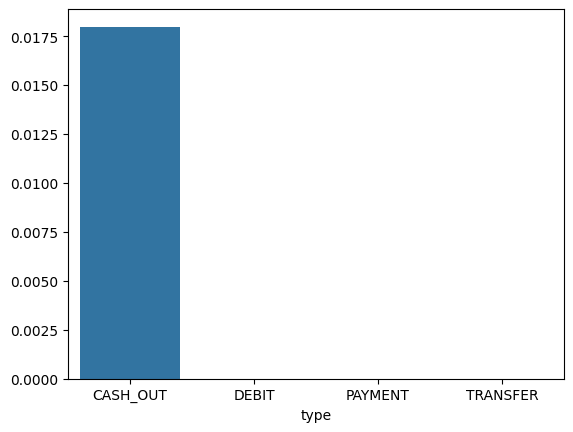

In [16]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print(fraud_by_type)
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)

From here we understand that most if not all the frauds that occured were in the CASH_OUT transaction type. So cash is more prone to frauds than its digital counterparts.

### Amount distribution for frauds
Compares distribution of amount for fraudulent and non-fraudulent transactions.

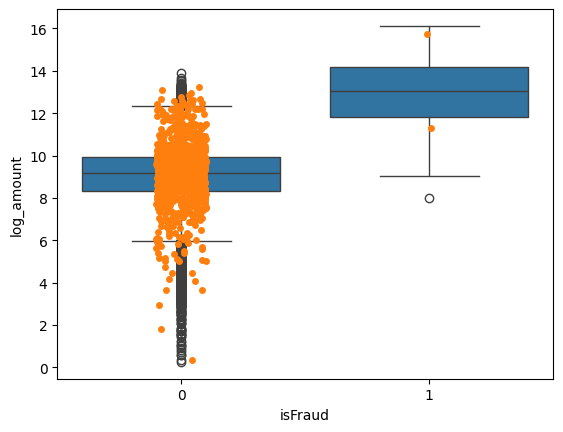

In [17]:
sns.boxplot(x='isFraud', y='log_amount', data=df)
sns.stripplot(x='isFraud', y='log_amount', data=df.sample(1000, random_state=42), jitter=True)
plt.show()

We are using log_amount instead of amount as the plot using amount is hard to understand from the visual itself, given below. Log normalizes the value for gaining insights.

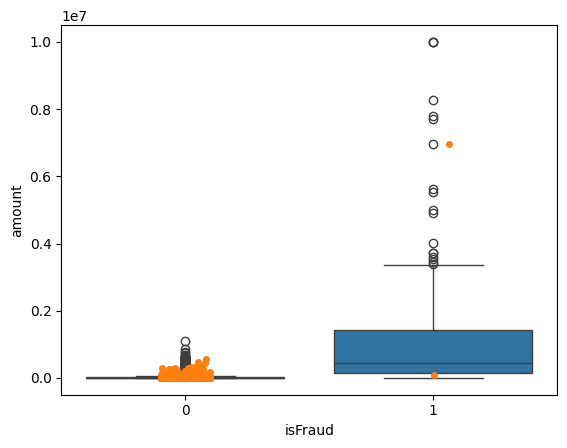

In [18]:
sns.boxplot(x='isFraud', y='amount', data=df)
sns.stripplot(x='isFraud', y='amount', data=df.sample(1000, random_state=42), jitter=True)
plt.show()

### Fraud by time
This answers the question of does fraud happen more during certain hours of the day.

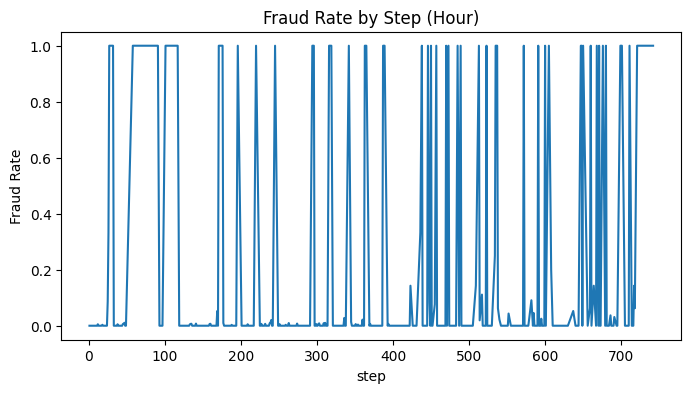

In [19]:
fraud_by_step = df.groupby('step')['isFraud'].mean()
fraud_by_step.plot(kind='line', title='Fraud Rate by Step (Hour)', xlabel='step', ylabel='Fraud Rate', figsize=(8,4))
fraud_counts = df[df['isFraud'] == 1]['step'].value_counts().sort_index()

Since 1 step means 1 hour, we have over 30 days worth or data from the graph.

Fraud occur in highly clustered forms, like some time frames have near zero fraud whereas there are spikes of fraud with great intensity over short bursts of time.

### Correlation heatmap
Correlations in numeric form for cross checking or getting numbers for the data.

Text(0.5, 1.0, 'Correlation Heatmap')

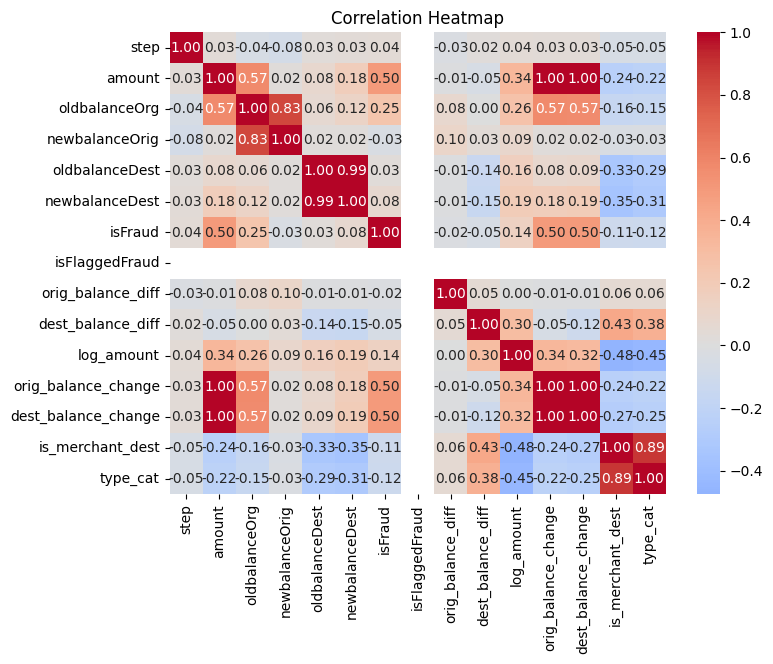

In [20]:
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')

It just shows that there are correlations between basic stuff
- Fraud and amount are correlated - Fraudulent transactions tend to involve higher amounts.
- Fraud and account balance - When fraud occurs there are changes in the various balances, i.e. in newbalanceOrig, oldbalanceOrig, etc.
- Low correlation between `isFlaggedFraud` and other variables - So the rule of flagging transactions over 2,00,000 is not a very affective indicator of actual fraudulent activity.

## Model training

### Add Train / Validation Split
For preventing data leakage, and preparing training and validation sets.

In [21]:
label = 'isFraud'

if 'step' in df.columns:
    df = df.sort_values('step').reset_index(drop=True)
    split = int(0.7 * len(df))
    train_df = df.iloc[:split]
    val_df   = df.iloc[split:]
else:
    train_df, val_df = train_test_split(df, test_size=0.3, stratify=df[label], random_state=RSEED)

X_train, y_train = train_df[features], train_df[label].astype(int)
X_val, y_val     = val_df[features], val_df[label].astype(int)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

Train shape: (29268, 5) Val shape: (12544, 5)


## Class imbalance handling
Frauds are rare, so to predict with high accuracy and correcting imbalances when training LightGBM.

In [22]:
pos = y_train.sum()
neg = len(y_train) - pos
spw = neg / max(1, pos)
print("scale_pos_weight:", spw)

scale_pos_weight: 456.3125


### Sanity checks
For verifying that the splits used in training and validation are correct and confirming class imbalances before modeling.

In [23]:
# ensure you have fraud examples and shapes
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)
print("Train fraud count:", y_train.sum(), "Val fraud count:", y_val.sum())

Train shape: (29268, 5) Val shape: (12544, 5)
Train fraud count: 64 Val fraud count: 68


### Model parameters and training
Using of LightGBM for modeling on tabular data and using class fitting to handle any imbalances.

In [24]:
# recompute scale_pos_weight if needed
pos = int(y_train.sum()); neg = len(y_train) - pos
scale_pos_weight = neg / max(1, pos)
print("scale_pos_weight:", scale_pos_weight)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',            # we will compute PR-AUC separately
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'n_jobs': -1,
    'seed': RSEED,
    'verbosity': -1,
    'scale_pos_weight': scale_pos_weight
}

dtrain = lgb.Dataset(X_train, label=y_train)
dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)

from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

scale_pos_weight: 456.3125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.964749	valid's auc: 0.949982


Insights drawn
- There are 529 or close to 530 frauds in the sample set we took.
- Model found optimal point early on at 21 rounds.

### Save model and feature list
Saves the trained model and feature list to disk allowing for reproducing the environment for future use or deployment.

In [25]:
# LightGBM native save
model.save_model("lgbm_fraud_model.txt")

# Save Python-side artifacts (feature list)
joblib.dump(features, "features_list.joblib")

['features_list.joblib']

### Core evaluation
- Calculating PR-AUC and ROC-AUC.
- Finding the best classification threshold using F1 score.
- Measures precision and recall at the threshold found.

In [26]:
y_prob = model.predict(X_val, num_iteration=model.best_iteration)
pr_auc = average_precision_score(y_val, y_prob)
roc_auc = roc_auc_score(y_val, y_prob)
print(f"PR-AUC: {pr_auc:.4f}   ROC-AUC: {roc_auc:.4f}")

# choose threshold maximizing F1
prec, rec, thr = precision_recall_curve(y_val, y_prob)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best F1 threshold:", best_thr, "F1:", f1[best_idx])


PR-AUC: 0.0274   ROC-AUC: 0.8928
Best F1 threshold: 1.0 F1: 0.05396697543289074


### Confusion matrix & precision / recall
Provides visual as well as numeric understanding of true vs. false positives / negatives which helps in understanding and assessing the real-world impact of the fraud detection.

In [27]:
best_threshold = float(best_thr)
y_pred = (y_prob >= best_threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)
print("Precision:", precision_score(y_val, y_pred, zero_division=0))
print("Recall:", recall_score(y_val, y_pred, zero_division=0))

Confusion matrix:
 [[10128  2348]
 [    1    67]]
Precision: 0.02774327122153209
Recall: 0.9852941176470589


### Precision@k
Measures how many top 1% or so predicted frauds are correct, thus allowing for prioritization in transaction reviews or alerts.

In [28]:
def precision_at_k(y_true, y_score, k_frac=0.01):
    k = max(1, int(len(y_score) * k_frac))
    idx = np.argsort(y_score)[-k:]
    return y_true.iloc[idx].mean(), k

prec_at_1pct, k = precision_at_k(y_val.reset_index(drop=True), pd.Series(y_prob), 0.01)
print(f"Precision@{k} (top 1%): {prec_at_1pct:.4f}")

Precision@125 (top 1%): 0.0400


### Various plots
Plot various useful graphs and plots like PR curve, ROC curve, confusion matrix heatmap for visually gaining insights and explaining to stakeholders.

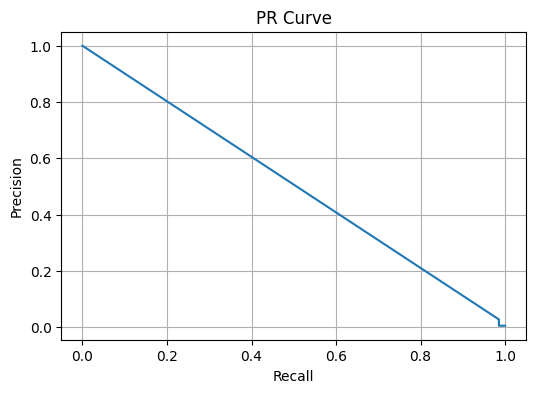

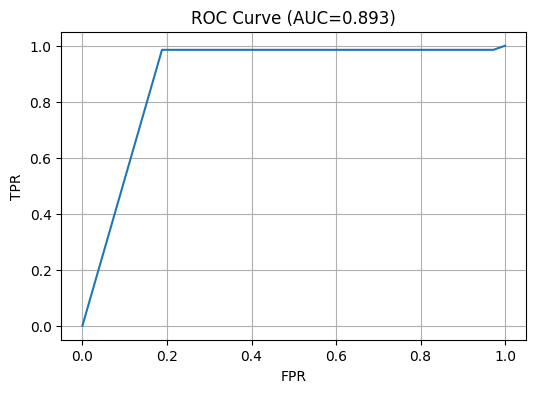

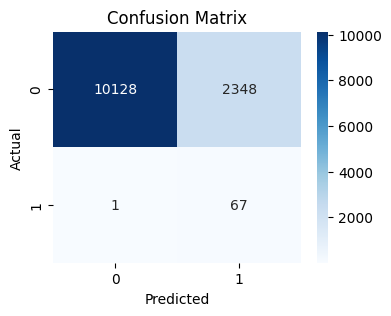

In [29]:
# PR curve
prec, rec, _ = precision_recall_curve(y_val, y_prob)
plt.figure(figsize=(6,4)); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.grid(True); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.figure(figsize=(6,4)); plt.plot(fpr, tpr); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curve (AUC={roc_auc:.3f})'); plt.grid(True); plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(4,3)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.show()

### Feature and stability check
Displays the feature list and reliability on those features in a comparative order.

In [30]:
fi = pd.DataFrame({
    'feature': features,
    'gain': model.feature_importance(importance_type='gain'),
    'split': model.feature_importance(importance_type='split')
}).sort_values('gain', ascending=False)
print(fi)

               feature          gain  split
2  dest_balance_change  4.698661e+10    468
0           log_amount  1.456786e+10    602
4             type_cat  2.290353e+08     82
3     is_merchant_dest  1.440080e+06      5
1  orig_balance_change  0.000000e+00      0


### SHAP interpretation
Applies SHAP to interpret and explain individual predictions and global patterns, thus providing a reasoning behind why a fraud flag is raised.

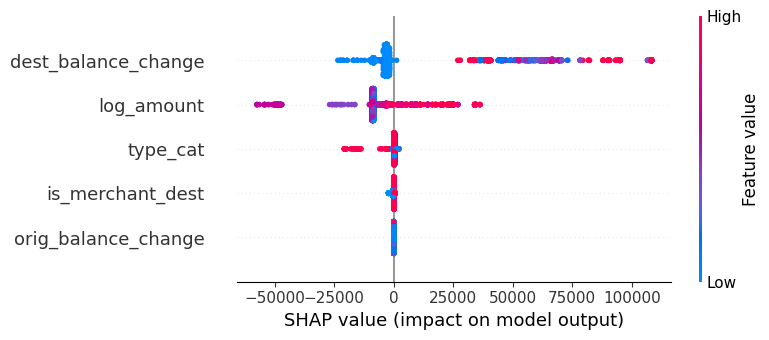

In [31]:
# Limit sample size for speed
Xshap = X_val.sample(n=min(5000, len(X_val)), random_state=RSEED)
# SHAP recently updated how it returns shap_values for binary classification models like LightGBM.
# Older versions returned a list: [shap_values_class0, shap_values_class1]
# Newer versions return a single 2D NumPy array with SHAP values for the positive class (fraud = 1).
# Warning is issued to make this change aware. This warning does not impact results or plots.
# The warning is suppressed to keep the notebook output clean and avoid confusion.
import warnings
warnings.filterwarnings("ignore", message=".*LightGBM binary classifier with TreeExplainer.*")
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
# Compute SHAP values — returns a matrix in newer SHAP versions
shap_values = explainer.shap_values(Xshap)
# Plot summary directly (no [1] indexing)
shap.summary_plot(shap_values, Xshap)

To summarize, the model relies on the change in the destination balance and the logarithm of the transaction amount to predict fraudulent activities. The type of transaction plays a role as most if not all of the frauds occur in the CASH_OUT segment.

### Save final artifacts
Saving outputs like model, validation, predictions, metrics. Allowing reuse, audit and reporting of the findings.

In [32]:
# save model already done; save predictions and key metrics
import json
pd.DataFrame({'y_true': y_val.reset_index(drop=True), 'y_prob': y_prob}).to_csv("val_predictions.csv", index=False)
metrics = {'pr_auc': float(pr_auc), 'roc_auc': float(roc_auc), 'precision_at_1pct': float(prec_at_1pct), 'best_threshold': float(best_threshold)}
with open("metrics.json","w") as f:
    json.dump(metrics, f, indent=2)
joblib.dump(model, "lgbm_model.joblib")   # optional redundancy

['lgbm_model.joblib']

## Conclusion and Findings

### Brief description of the model
I used LightGBM to build a gradient-boosted decison-tree model to predict fraudlent transactions. Data such as log_amount, orig_balance_change, dest_balance_change, is_merchant_dest and type_cat to train the model with a time-aware split. Since the fraud is highly imbalanced, the model was trained with scale_pos_weight set to the training class imbalance. Early stopping and best iteration was used to determine the optimal conditions for the model. Final performance on the validation set using ROC-AUC and PR-AUC was done. The mode is afst, interpretable (via SHAP), reproducible for mass deployment.

### Variable selection though process
Variables were selection with a mix of domain logic, EDA and model-driven importance
- Balance deltas like changes in the original and destination balance were made. Using log_amount reduces skew in the real data and produces practical insights for further use.
- EDA showed where the focus should be to find and train the data to find fraudulent transactions.

### Performance demonstration
We evaluated the model with ranking and classification metrics suited for imbalanced fraud detection:

Primary: Precision-Recall AUC (PR-AUC) because it reflects performance on rare positive class. PR-AUC = 0.0282

Secondary: ROC-AUC = 0.8912

Business metric: Precision@Top-k (top 1%), computed as the proportion of true frauds in the top predicted 1% of scores → Precision@1% = 0.0400

Thresholding & confusion matrix: We selected a threshold that maximizes F1 on the validation set, these are included above in the notebook.
Visuals: include PR curve, ROC curve and confusion matrix heatmap — these are produced in the notebook and show model discrimination and operating point tradeoffs.

### Key factors that predict fraudulent customer
Based on the outputs received from the model
- `dest_balance_change` - Large positive changes in the destination after a transfer often indicate money being moved to a cash-out endpoint.
- `log_amount` - Unusually large transactions (in log scale) increase fraud probability.
- Transaction type - CASH_OUT and sequences of TRANSFER -> CASH_OUT are strongly associated with fraud.

### Relation with real world situation
- Fraudsters commonly move funds from one place to another and then quickly cash out, thus making a large transfer sequence followed by a cash out sequence a classic fraud signature.
- Large log_amounts as high value transfers are attractive for attackers.
- The low correlation between isFlaggedFraud and other variables shows that simple rules like transactions over 2,00,000 are not suitable, the model combines various other parameters to give a much more accurate predication for fraudulent activities.

### Prevention recommendation
- Real time scoring by applying the model in real time with lightweight rules to triage transactions.
- Implement transaction sequence checks, like TRANSFER followed by CASH_OUT with X hours, block or require additional authentication for such actions.
- Setup more authentications, like real time otp or totp, device fingerprinting. For high risk transactions have manual review.
- Ensure all data is kept with valid timestamps and backed up properly.
- Provide fraud analysts with model score, recent transaction history for expedited decisions.
- Compute only lightweight features at ingestion and compute heavier aggregates asynchronously to minimize latency.

### How to determine whether prevention recommendations work
- A/B testing and then comparing the two segments.
- Tracking key metrics, like fraud loss incurred, detection rate, false positives and operational costs, % of true frauds in top-k alerts.
- Feedback loops to analyze monthly or quaterly data.
- Making dashboard with direct pipeline to data to see real time insights from the implementation.

### Further the model can be tested on the entire or even bigger dataset if computational resources are available for historical testing.